In this notebook, we revisit the CIFAR example and construct a CNN network again, but will take a look at some ways how we can get some insights in its workings.

In [ ]:
%tensorflow_version 2.x

from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from PIL import Image
from scipy.optimize import fmin_l_bfgs_b
from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train /= 255
X_test  /= 255
y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step


We'll work with our best performing CNN network from the earlier example here, though if you'd like, feel free to change up this architecture.

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        4640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       7

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 128
epochs     = 15

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/15
391/391 [==============================] - 17s 43ms/step - loss: 1.5550 - accuracy: 0.4241 - val_loss: 1.9222 - val_accuracy: 0.2824
Epoch 2/15
391/391 [==============================] - 17s 42ms/step - loss: 1.2598 - accuracy: 0.5477 - val_loss: 1.2463 - val_accuracy: 0.5469
Epoch 3/15
391/391 [==============================] - 16s 42ms/step - loss: 1.1255 - accuracy: 0.6000 - val_loss: 1.0814 - val_accuracy: 0.6101
Epoch 4/15
391/391 [==============================] - 17s 42ms/step - loss: 1.0269 - accuracy: 0.6388 - val_loss: 1.0914 - val_accuracy: 0.6133
Epoch 5/15
391/391 [==============================] - 16s 42ms/step - loss: 0.9593 - accuracy: 0.6640 - val_loss: 1.1041 - val_accuracy: 0.6204
Epoch 6/15
391/391 [==============================] - 16s 42ms/step - loss: 0.9053 - accuracy: 0.6805 - val_loss: 0.9245 - val_accuracy: 0.6831
Epoch 7/15
391/391 [==============================] - 16s 42ms/step - loss: 0.8611 - accuracy: 0.6972 - val_loss: 0.9051 - val_accuracy:

# Layer activations

We can now start by taking a look at out network and what is has learned.

First, we can take an example image and take a look how it activates the convolutional filters.

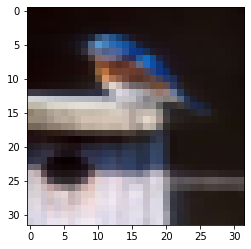

In [ ]:
plt.imshow(X_train[13])
plt.show()

We have the following convolutional layers available in our network:

In [ ]:
conv_layers = [layer.name for layer in model.layers if layer.name.startswith('conv2d')]
conv_layers

['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4']

The question is now how we can get access to activations of intermediate layers. For this, we'll define a custom Keras function.

In [ ]:
def get_layer_output(model, layer_name):
  return K.function(inputs=model.inputs, outputs=[model.get_layer(layer_name).output])

Next, for each convolutional layer, we get the activations, and then visualize them filter by filter:

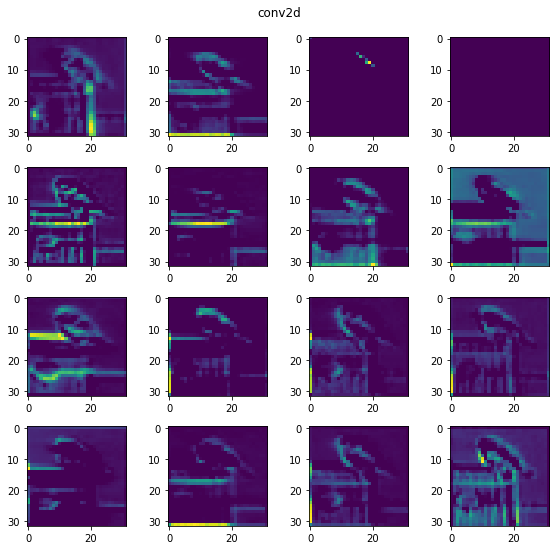

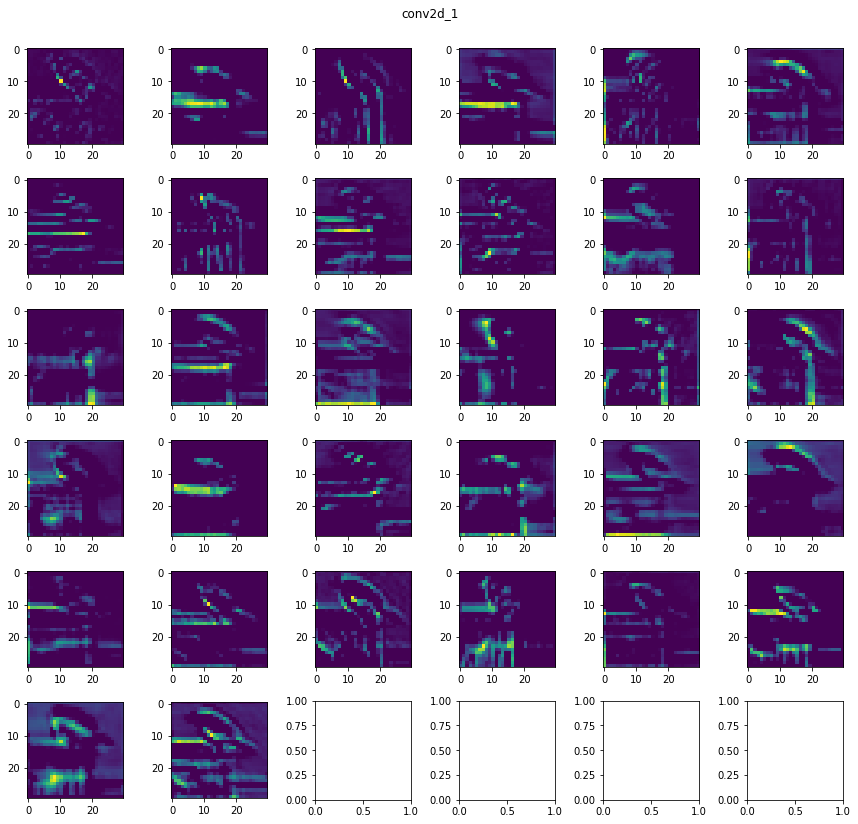

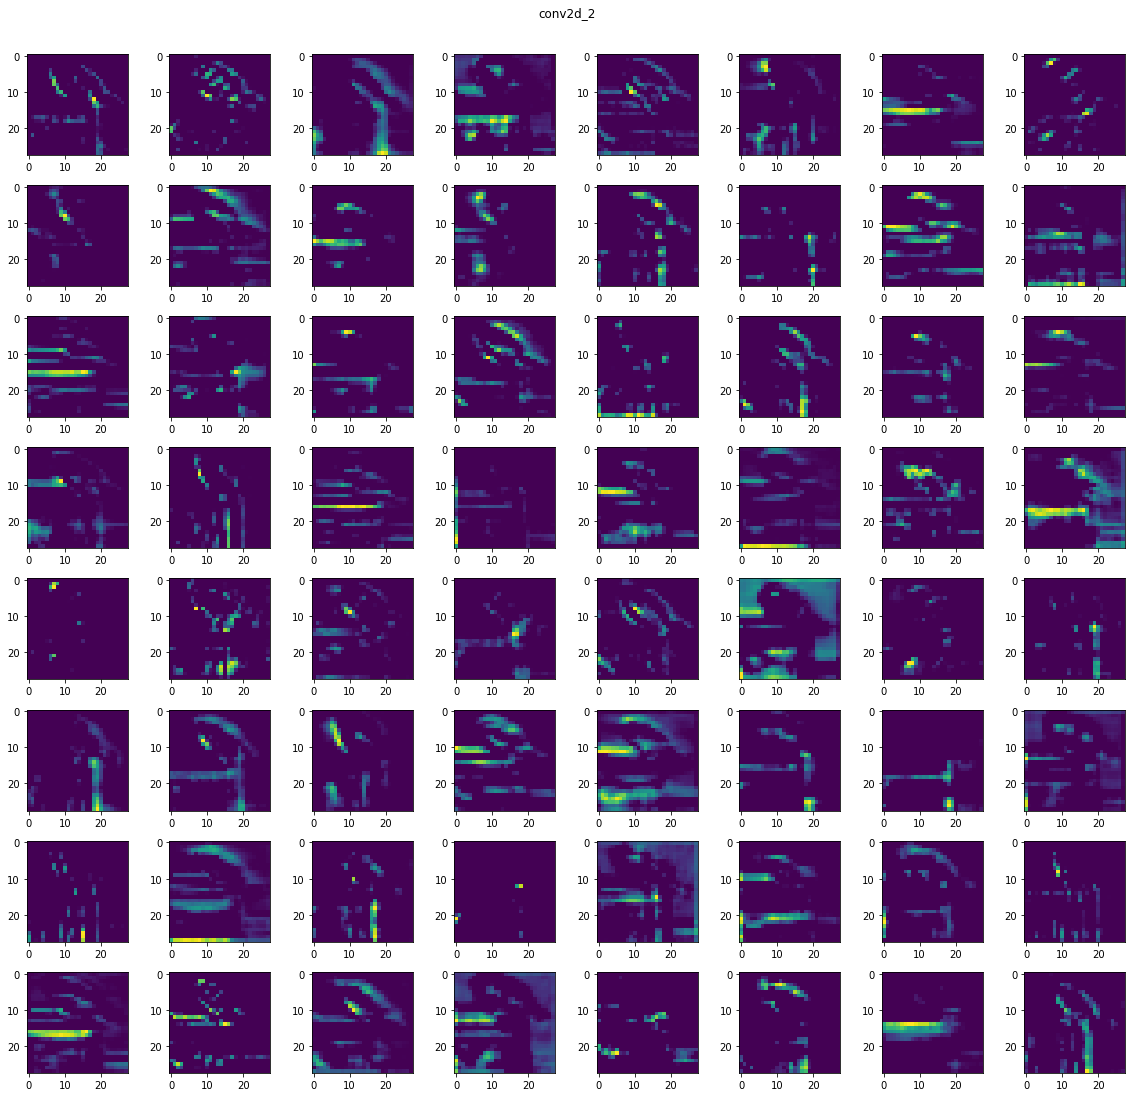

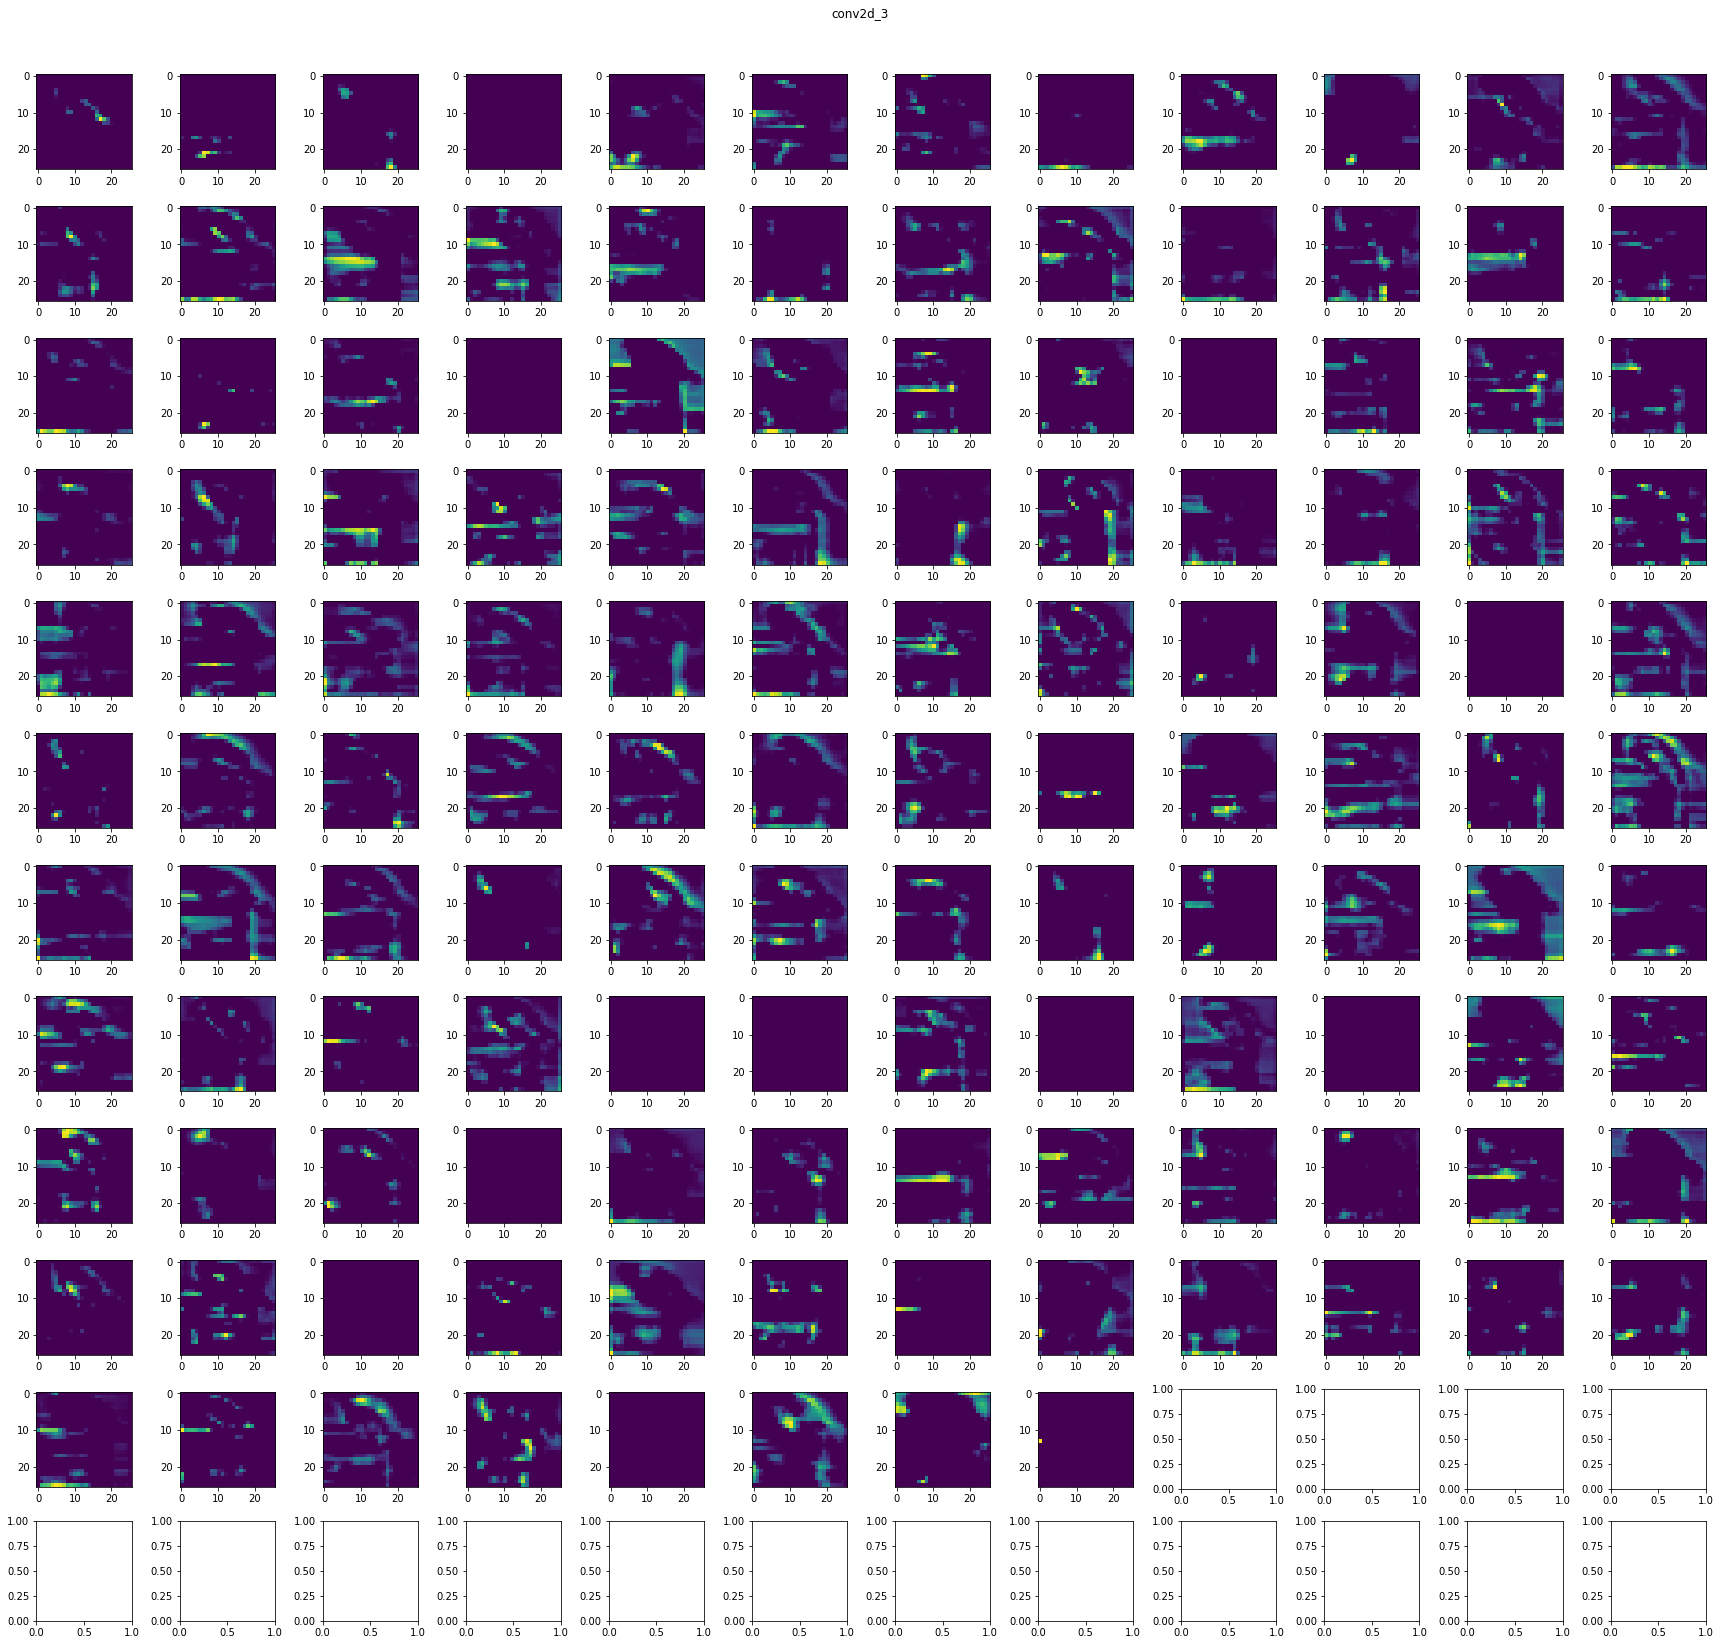

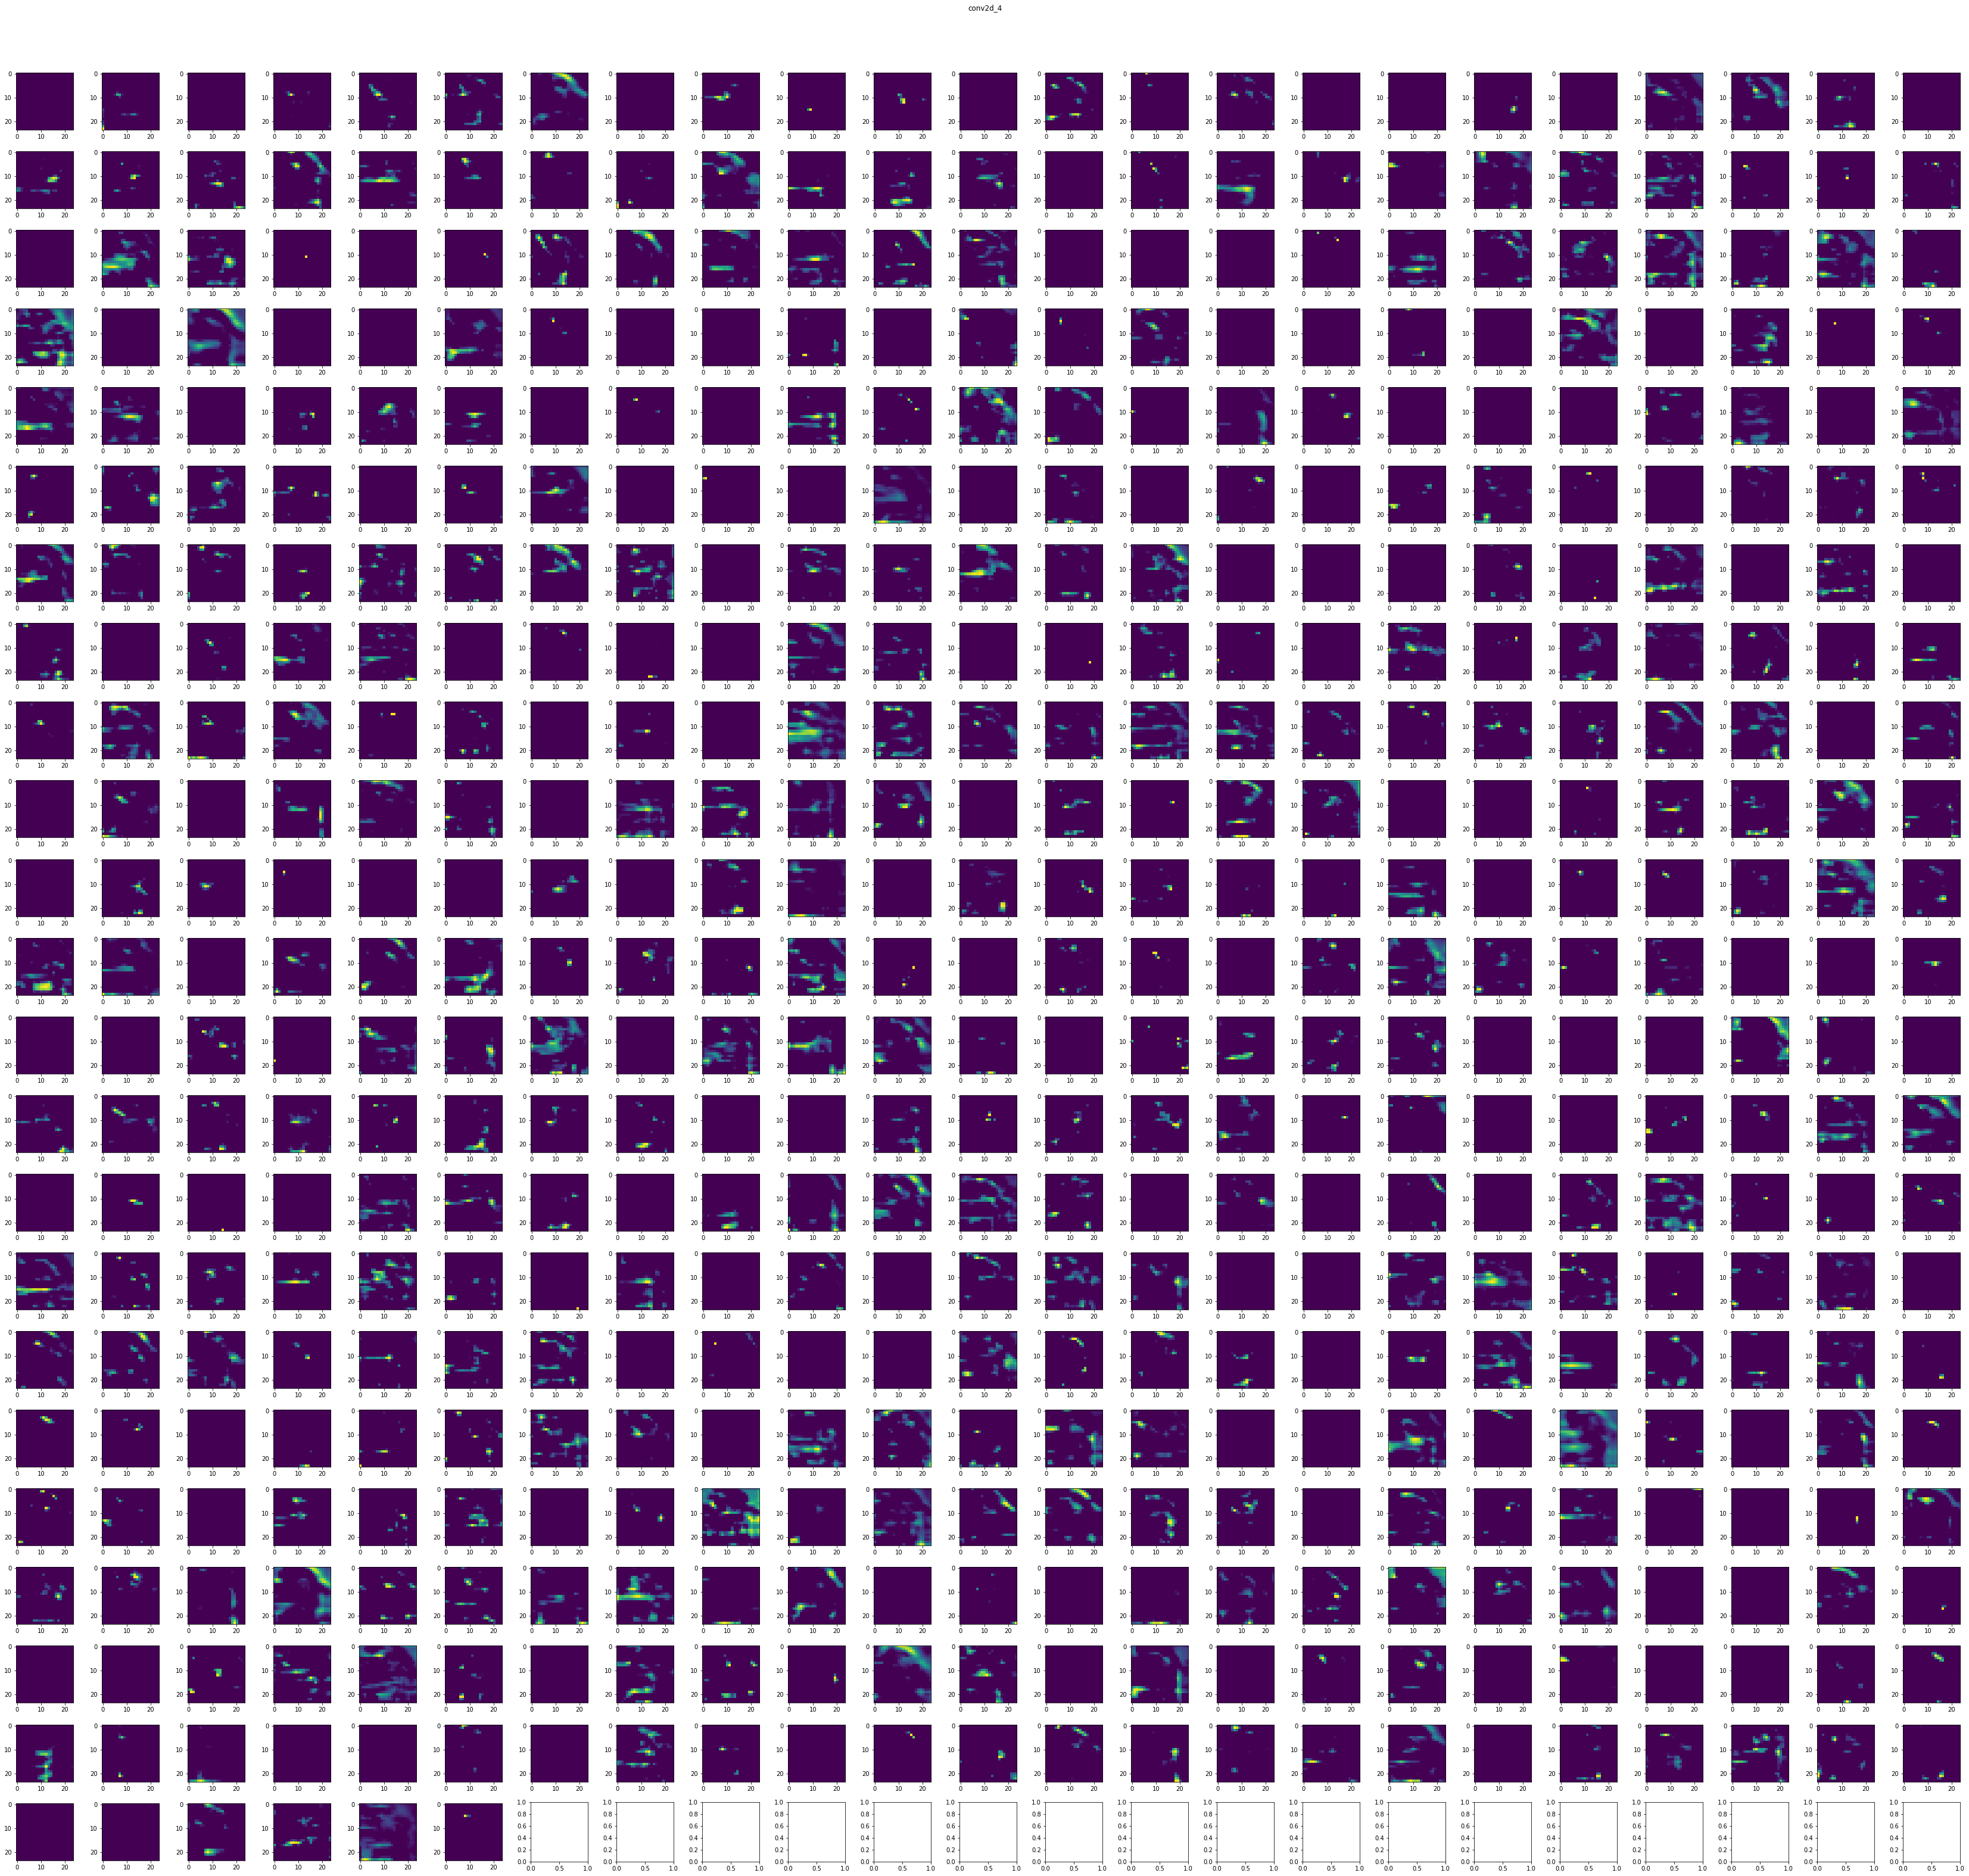

In [ ]:
test_instance = X_train[13]

for layer_name in conv_layers:
  num_filters     = model.get_layer(layer_name).output_shape[-1]
  get_activations = get_layer_output(model, layer_name)
  activations     = get_activations(np.expand_dims(test_instance, axis=0))[0][0]
  rows_cols       = int(np.ceil(np.sqrt(num_filters)))
  fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
  fig.suptitle(layer_name)
  for filter_idx in range(num_filters):
    ax[filter_idx // rows_cols][filter_idx % rows_cols].imshow(activations[:,:,filter_idx])
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

We can clearly see that the lower layers have learned to focus on color and edges, and the last layer basically representing an abstract feature map to be picked up by the global average pooling layer!

# Convolutional filters

Next up, we'll take a look at the weights of the convolutional units. Here, we only visualize the weights for the `conv2d_2` layer:

In [ ]:
# get_weights() outputs two tensors: the second one are the biases, which we won't show here

model.get_layer('conv2d_2').get_weights()[0].shape, model.get_layer('conv2d_2').get_weights()[1].shape

((3, 3, 32, 64), (64,))

However, we have an issue here. The shape of the weights is `(3, 3, 32, 64)`. In other words, we have 64 filters, each with a kernel of 3x3x32, as the previous layer creates 32 filters.

There are some ways how we can fix this... We could show each "slice" over the depth one by one for a single filter or kernel:

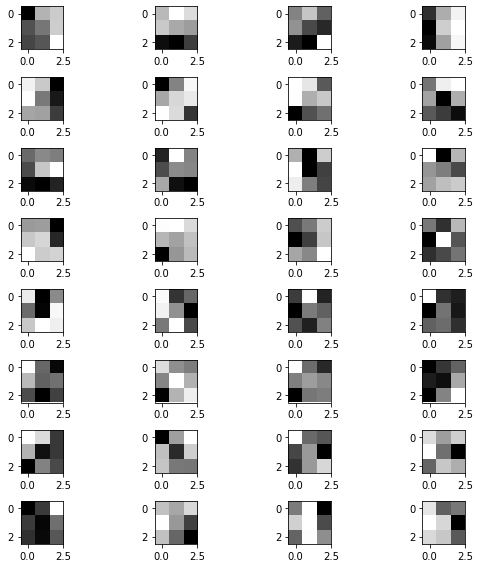

In [ ]:
fig, ax = plt.subplots(8, 4, figsize=(8, 8))
for i in range(model.get_layer('conv2d_2').get_weights()[0].shape[2]):
  ax[i // 4][i % 4].imshow(model.get_layer('conv2d_2').get_weights()[0][:, :, i, 0], cmap='gray')
fig.tight_layout()

However, this is quite cumbersome as we would like to show all 64 kernels...

For the first convolutional layer, this does work as we there have a weight shape of `(3, 3, 3, 16)`, so we can show all 16 filters at once, coloring them based on their depth (which is 3 here).

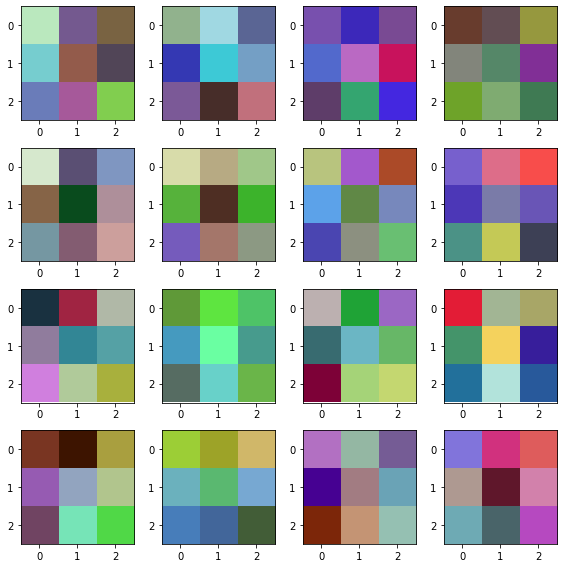

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i in range(model.get_layer('conv2d').get_weights()[0].shape[-1]):
  weights = model.get_layer('conv2d').get_weights()[0]
  ax[i // 4][i % 4].imshow(
    (weights[:, :, :, i] - np.min(weights)) / (np.max(weights) - np.min(weights))
  )
fig.tight_layout()

Still, the filters are small and not easy to understand, and this approach seems difficult for the higher-level layers.

What we'd like instead is to know what to which type of pattern a filter reacts. In other words, for which inputs the activations of a particular filter goes up.

How do we create such a pattern? In essence we're faced with another optimization problem. We want to maximize the activation of a given convolutional unit by changing around an input image. We could use SGD for that, and we could even define a separate neural network to find such an image.

However, given that the task here is relatively constrained, we can also use a standard optimization techniques such as the [ones found in SciPy](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html).

Here is what we will do: first, we'll define a new computational graph taking as the input an image and returning as the output the activation of a certain convolutional unit. We'll then optimize this using [`fmin_l_bfgs_b`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html). Since this function (just like SGD) also needs the gradients, we'll ask Keras to calculate them for us.

Since we're going to reuse this technique for some other examples later on, it's a good idea to set this up in a generic way, so we're going to write a generic class for this:

In [ ]:
class KerasFunctionOptimizer(object):
  def __init__(self, input_shape):
    # We need to disable TensorFlow's eager execution for the following to work
    # "Eager execution" refers to a define-by-run interface where operations are executed immediately 
    # as they are called from Python, which is the default for TensorFlow 2
    # We don't want that here, so we disable it
    from tensorflow.python.framework.ops import disable_eager_execution
    disable_eager_execution()
    self.input_tensor = Input(batch_shape=(1,) + input_shape)

  def configure_losses(self, losses):
    # We can't do this in init as the user might want to use the input_tensor
    self.loss         = K.variable(0.)
    for loss in losses: self.loss = self.loss + loss
    self.gradients    = K.gradients(self.loss, self.input_tensor)
    self.outputs      = [self.loss, self.gradients]
    self.function     = K.function([self.input_tensor], self.outputs)

  def _evaluate(self, x):
    # fmin_l_bfgs_b works on a 1d array, so we reshape x in the format our model expects
    x = x.reshape(self.input_tensor.shape)
    outputs = self.function([x])
    return outputs[0], np.array(outputs[1:]).flatten().astype('float64')

  def _get_loss(self, x):
    self.last_loss, self.last_gradients = self._evaluate(x)
    return self.last_loss

  def _get_gradients(self, x):
    return np.copy(self.last_gradients)

  def optimize(self, x, **args):
    # fmin_l_bfgs_b works on a 1d array, so we flatten x
    x, min_val, info = fmin_l_bfgs_b(self._get_loss, x.flatten(), fprime=self._get_gradients, **args)
    return x.reshape(self.input_tensor.shape[1:]), min_val, info

We're going to optimize images with a size of `(100, 100, 3)`. This is different from the input shape of our original model, so we're going to need to clone our model, replacing the input tensor. Additionally, we need to copy the weights from the old model to the cloned one.

Since `K.gradients` only works (easily) when TensorFlow's eager mode is disabled, we also do so in the class above. However, this also invalidates all the computational graphs (and weights) we've constructed so far, so we *first* story a copy of the weights so we can set them once we create our optimizer object.

In [ ]:
original_weights = {layer.name: layer.get_weights() for layer in model.layers}

We can now create the optimizer, use the new input tensor in the cloned model (this is easily done thanks to `clone_model`), and copy the weights.

In [ ]:
optimizer = KerasFunctionOptimizer((100, 100, 3))

new_model = clone_model(model, input_tensors=[optimizer.input_tensor])
new_model.summary()
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

for layer in new_model.layers:
  layer.set_weights(original_weights[layer.name])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 100, 100, 16)         448       
_________________________________________________________________
dropout (Dropout)            (1, 100, 100, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 98, 98, 32)           4640      
_________________________________________________________________
dropout_1 (Dropout)          (1, 98, 98, 32)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 96, 96, 64)           18496     
_________________________________________________________________
dropout_2 (Dropout)          (1, 96, 96, 64)           0         
_________________________________________

Next, we create a helper function to generate an optimized image, maximizing the mean activation of a convolutional filter in a given layer. We make the loss negative as `fmin_l_bfgs_b` minimizes the objective function.

In [ ]:
def get_optimized_image(new_model, layer_name, optimizer, filter_idx):
  optimizer.configure_losses([
    - K.mean(K.abs(new_model.get_layer(layer_name).output[0, :, :, filter_idx]))
    # First output, first instance, all activations for the first filter
  ])

  img_optimized = np.random.random(optimizer.input_tensor.shape[1:])
  bounds = [(0,1) for _ in range(len(img_optimized.flatten()))]
  img_optimized, min_val, info = optimizer.optimize(img_optimized, bounds=bounds)
  return img_optimized

We can then loop over some layers, and visualize which images each filter likes...

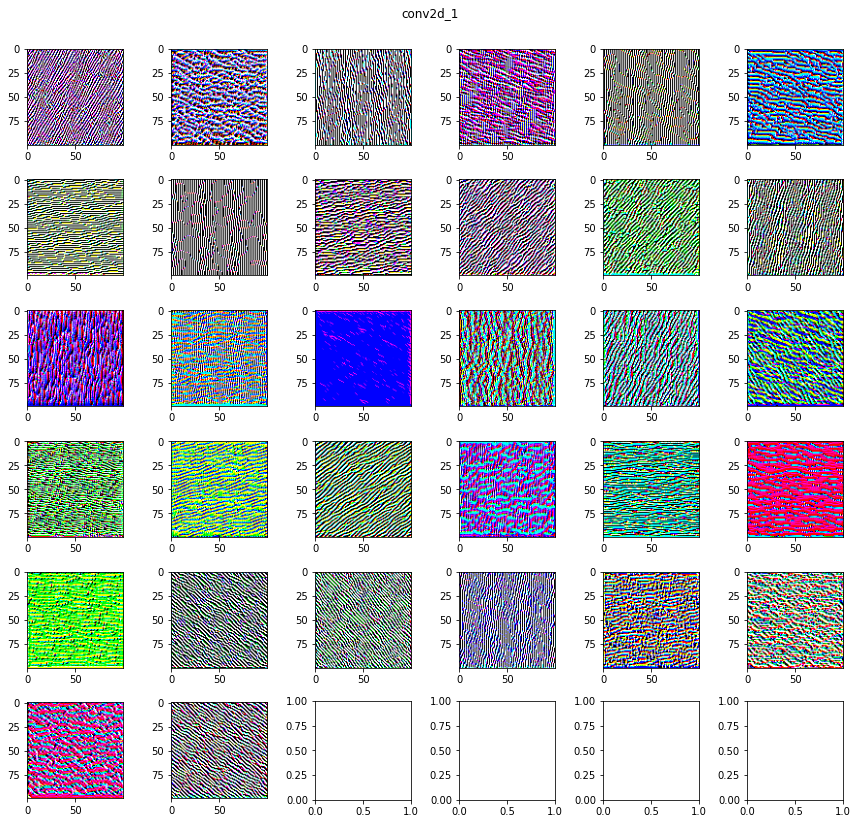

In [ ]:
# We're only going to do a one layer here to save on time... feel free to try some of the others
conv_layers = ['conv2d_1']

for layer_name in conv_layers:
  num_filters = new_model.get_layer(layer_name).output_shape[-1]
  rows_cols   = int(np.ceil(np.sqrt(num_filters)))
  fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
  fig.suptitle(layer_name)
  for filter_idx in range(num_filters):
    optimized = get_optimized_image(new_model, layer_name, optimizer, filter_idx)
    ax[filter_idx // rows_cols][filter_idx % rows_cols].imshow(optimized)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

We can see that some filters focus heavily on color, whereas others have a preference towards looking at stripe-like patterns!

Note: in the paper "Visualizing deep convolutional neural networks using natural pre-images", some additional losses are added in to regularize the input image, to make it look more human-interpretable, using e.g. [L-p norm loss](https://en.wikipedia.org/wiki/Lp_space) and [total variation based loss](https://en.wikipedia.org/wiki/Total_variation_denoising). We don't do so here, which is why the images above look a bit wacky, but will do so for some examples later on.

Before we continue, let's make a copy of our model once again to make sure the code examples below can simply continue to use `model` instead of `new_model` (this is a bit easier to type).

In [ ]:
model = clone_model(model)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

for layer in model.layers:
  layer.set_weights(original_weights[layer.name])

# Maximally activating images

There is actually an easier approach we can take. Instead of optimizing an input image towards maximally exciting a convolutional neuron, we can use our large amount of training image and just inspect these to see which ones excite a particular neuron the most.

In [ ]:
# Recall the function we have defined before:

def get_layer_output(model, layer_name):
  return K.function(inputs=model.inputs, outputs=[model.get_layer(layer_name).output])

First, we define a similar function as the loss used above to get the mean activation of a convolutional neuron -- it's "excitement". We define a batch size so as to keep memory consumption a bit under control.

In [ ]:
def get_excitement(images, model, layer_name, filter_idx, batch_size=128):
  excitements = np.array([])
  get_activations = get_layer_output(model, layer_name)
  for i in range(0, len(images), batch_size):
    activations = get_activations(images[i:i+batch_size])[0][:, :, :, filter_idx]
    excitements = np.hstack([excitements, np.mean(np.abs(activations), axis=(1, 2))])
  return excitements

Let's plot what one filter thinks of our training images:

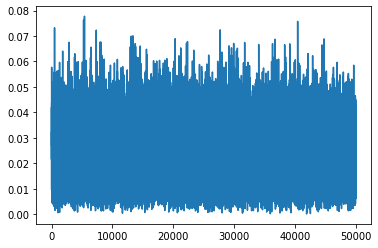

In [ ]:
plt.plot(get_excitement(X_train, model, 'conv2d_1', 0))

Let's now show which images are most exciting for a given filter:

In [ ]:
def show_exciting_images(images, model, layer_name, filter_idx, num_to_show=4):
  excitements     = get_excitement(images, model, layer_name, filter_idx)
  excitements_idx = np.argsort(excitements)[-num_to_show:]
  rows_cols   = int(np.ceil(np.sqrt(num_to_show)))
  fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
  for i, excitement_idx in enumerate(excitements_idx):
    ax[i // rows_cols][i % rows_cols].imshow(images[excitement_idx])
  fig.tight_layout()
  plt.show()

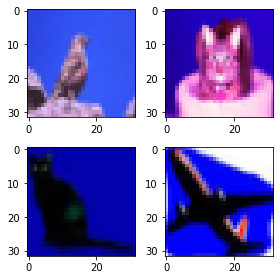

In [ ]:
show_exciting_images(X_train, model, 'conv2d_1', 14)

Cool, this filter is definitely looking for blue! (Note that your filter might be looking at something else if you re-run this notebook.) We can also visualize the most exciting image for each filter in a layer:

In [ ]:
def show_exciting_images_layer(images, model, layer_name):
  num_filters     = model.get_layer(layer_name).output_shape[-1]
  rows_cols       = int(np.ceil(np.sqrt(num_filters)))
  fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
  for filter_idx in range(num_filters):
    excitements     = get_excitement(images, model, layer_name, filter_idx)
    excitement_idx  = np.argsort(excitements)[-1:][0]
    ax[filter_idx // rows_cols][filter_idx % rows_cols].imshow(images[excitement_idx])
  fig.tight_layout()
  plt.show()

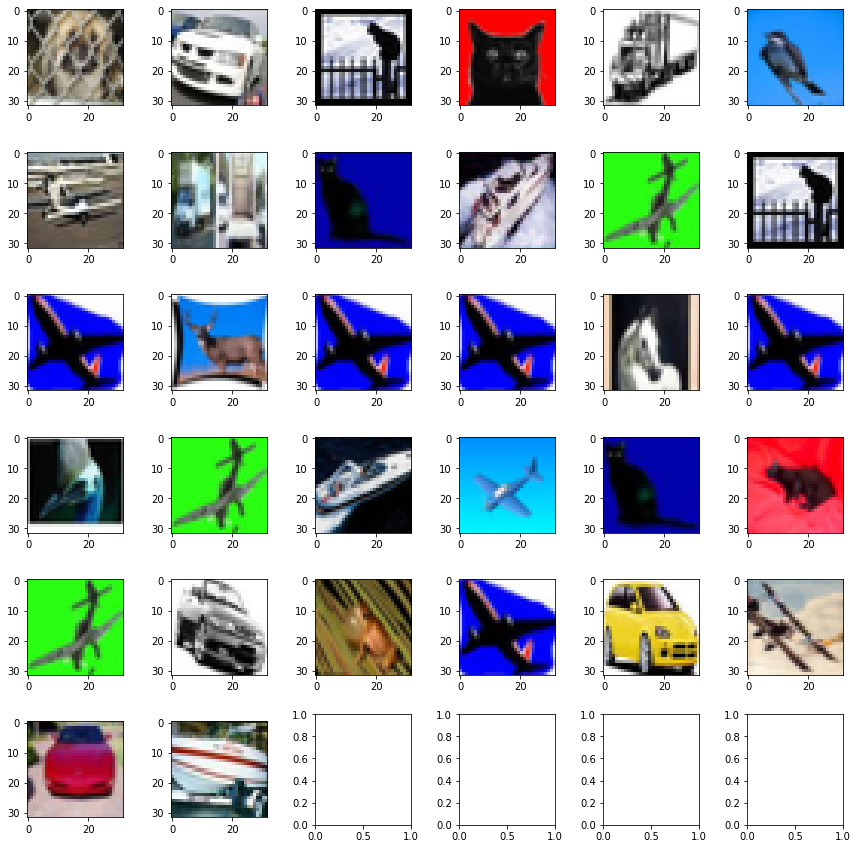

In [ ]:
show_exciting_images_layer(X_train, model, 'conv2d_1')

Compare this with the visualization we made before. Can you see similarities in terms of interpretation?

# Image occlusion

We can also try to gain an understanding by sliding an occlusion over the image and inspecting when the output of the network changes.

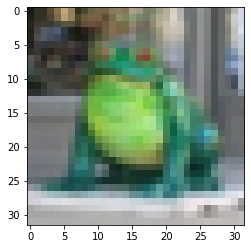

In [ ]:
test_instance = X_train[19]
plt.imshow(test_instance)

Next, we define a simple occlusion function:

In [ ]:
def occlude_image(img, pos=(0,0), size=6, color=(.5,.5,.5)):
  img = img.copy()
  img[pos[0]:pos[0]+size, pos[1]:pos[1]+size, :] = color
  return img

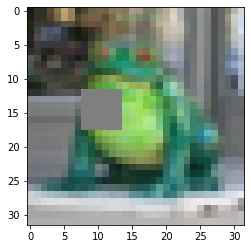

In [ ]:
plt.imshow(occlude_image(test_instance, pos=(12,8)))
plt.show()

And a function to generate all possible occlusions:

In [ ]:
def generate_occluded_images(img, **kwargs):
  if not 'size' in kwargs:
    kwargs['size'] = 6
  images = []
  for y in range(0, img.shape[0] - kwargs['size']):
    for x in range(0, img.shape[1] - kwargs['size']):
      images.append(occlude_image(img, pos=(y, x), **kwargs))
  return np.array(images)

In [ ]:
occlusion_size  = 8
occluded_images = generate_occluded_images(test_instance, size=occlusion_size)

We then ask our model to plot its predictions and compare them to the originally predicted class probability:

In [ ]:
original_pred = model.predict(np.array([test_instance]))[0]
original_pred, np.argmax(original_pred)

(array([0.02521353, 0.14957725, 0.2476094 , 0.34679526, 0.07072815,
        0.02366505, 0.08830548, 0.01278178, 0.00264859, 0.03267549],
       dtype=float32), 3)

In [ ]:
predictions = model.predict(occluded_images)
predictions.shape

(576, 10)

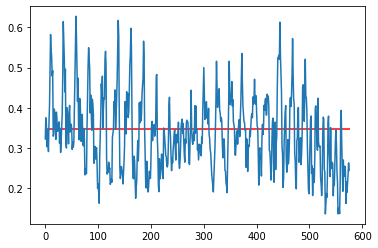

In [ ]:
plt.plot(predictions[:, np.argmax(original_pred)])
plt.hlines(original_pred[np.argmax(original_pred)], xmin=0, xmax=len(predictions), colors='r')

Let us now create a heatmap -- the more the probability drops, the more we'll highlight it:

In [ ]:
heatmap = np.zeros(test_instance.shape)

pred_idx = 0
for y in range(0, heatmap.shape[0] - occlusion_size):
  for x in range(0, heatmap.shape[1] - occlusion_size):
    prob = predictions[pred_idx, np.argmax(original_pred)]
    heatmap[y:y+occlusion_size, x:x+occlusion_size, :] += (1 - prob, 0, 0)
    pred_idx += 1

heatmap[:, :, 0] = minmax_scale(heatmap[:, :, 0])

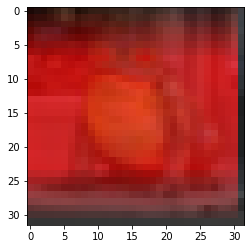

In [ ]:
plt.imshow(test_instance)
plt.imshow(heatmap, alpha=.7)

Based on the probabilities observed before, we can fine-tune this a bit further and put a threshold on the heatmap and only highlight the parts where the class prediction changes:

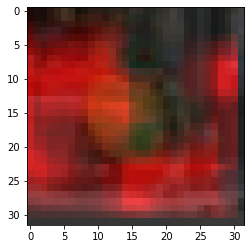

In [ ]:
heatmap = np.zeros(test_instance.shape)

pred_idx = 0
for y in range(0, heatmap.shape[0] - occlusion_size):
  for x in range(0, heatmap.shape[1] - occlusion_size):
    probs = predictions[pred_idx, :]
    if np.argmax(probs) != np.argmax(original_pred):
      heatmap[y:y+occlusion_size, x:x+occlusion_size, :] += (1, 0, 0)
    pred_idx += 1

heatmap[:, :, 0] = minmax_scale(heatmap[:, :, 0])

plt.imshow(test_instance)
plt.imshow(heatmap, alpha=.7)

# Saliency maps

Another approach we can try out, with a similar goal as image occlusion is saliency maps.

Again, we will make use of an optimization procedure here to find an image describing changes we would have to make to an original image in order to have the largest effect on the output.

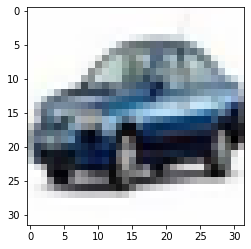

In [ ]:
test_instance = X_train[105]
plt.imshow(test_instance)

We fetch out the original class index and probability as we'll need them later.

In [ ]:
original_pred = model.predict(np.array([test_instance]))[0]
original_idx  = np.argmax(original_pred)
original_prob = original_pred[original_idx]
original_pred, original_idx, original_prob

(array([1.4481568e-09, 9.9986613e-01, 6.8216396e-13, 1.5452750e-10,
        1.0038527e-14, 3.1943307e-13, 7.1532596e-13, 8.9974105e-12,
        1.6259424e-11, 1.3382276e-04], dtype=float32), 1, 0.9998661)

Next, we need to override some functionality of our `KerasFunctionOptimizer` class. The reason for this is twofold. First, we don't want to create a new input tensor here but just use the input layer of our model. Second, we won't optimize an image directly, but rather optimize the changes (or "jitter") to add on top of the original image, as we want to go for small deviations.

In [ ]:
class JitterOptimizer(KerasFunctionOptimizer):
  def __init__(self, model, original_image):
    super().__init__(model.input.shape)
    self.input_tensor = model.input
    self.original_image = original_image

  def _evaluate(self, x):
    x = x.reshape((1,) + self.input_tensor.shape[1:])
    x = np.clip(x + self.original_image, 0, 1)
    outputs = self.function([x])
    return outputs[0], np.array(outputs[1:]).flatten().astype('float64')

Next up, we create the optimizer and define our loss. Here, loss is defined as the difference between the new probability and the original one (the lower the new probability gets, the lower the loss). On top of this, we also add in a regularization L1-style loss so as to keep the variations not too extreme.

In [ ]:
optimizer = JitterOptimizer(model, test_instance)

optimizer.configure_losses([
  model.get_layer('dense').output[0, original_idx] - original_pred,
  K.max(K.abs(model.input[0,:,:,:] - test_instance)) * 0.01 # lambda
])

We can then optimize. We use the `maxfun` parameter here to keep the optimization under control. This parameter and `lambda` above are set using experimentation.

Original probability: 0.9998661 -- new probability: 0.00026309522


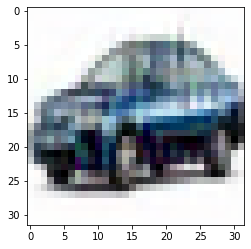

In [ ]:
img_optimized = np.zeros(optimizer.input_tensor.shape[1:])
img_optimized, min_val, info = optimizer.optimize(img_optimized, maxfun=15)

x = np.clip(test_instance + img_optimized, 0, 1)
new_prob = model.predict(np.array([x]))[0][original_idx]

print('Original probability:', original_prob, '-- new probability:', new_prob)
plt.imshow(x)

Interestingly enough, note that our image didn't change that much, and our neural network is convinced it isn't a car anymore! We can also visualize again using a heatmap the locations where our image changed the most:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


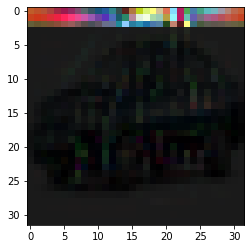

In [ ]:
heatmap = np.copy(img_optimized)
heatmap[0] = minmax_scale(heatmap[0])
heatmap[1] = minmax_scale(heatmap[1])
heatmap[2] = minmax_scale(heatmap[2])

plt.imshow(test_instance)
plt.imshow(heatmap, alpha=.9)

This is interesting -- our optimizer has made changes in the top rows of the image mainly!

Here are some more interesting things to try here:

- Is the interpretation above really interpretable yet? Try defining or coming up with a loss which makes sure we only change parts of the image that are "interesting". Interesting can be defined as e.g. non-white.
- Another loss function could punish on the number of pixels that are changed, keeping the number of pixels changed to a minimum.

The illustration above also highlights the aspect of "adversarial attacks" e.g. we can try to find an image where we only make minimal changes (by fine tuning `bounds` and removing the regularization):


Original probability: 0.9998661 -- new probability: 0.0012591934


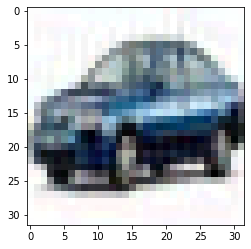

In [ ]:
optimizer = JitterOptimizer(model, test_instance)

optimizer.configure_losses([
  model.get_layer('dense').output[0, original_idx] - original_pred
])

img_optimized = np.zeros(optimizer.input_tensor.shape[1:])
bounds = [(-.025, .025) for _ in range(len(img_optimized.flatten()))]
img_optimized, min_val, info = optimizer.optimize(img_optimized, bounds=bounds, maxfun=15)

x = np.clip(test_instance + img_optimized, 0, 1)
new_prob = model.predict(np.array([x]))[0][original_idx]

print('Original probability:', original_prob, '-- new probability:', new_prob)
plt.imshow(x)

A lot has been written about the dangers of adversarial attacks in neural networks. One interesting paper to read through in this space is [Adversarial Examples Are Not Bugs, They Are Features](https://arxiv.org/abs/1905.02175).

# Dimensionality reduction with t-SNE

Finally, we can use dimensionality reduction techniques to lay out our input images in a two-dimensional map based on the activations of our neural network e.g. at the last-to-final dense layer or from the intermediate convolutional layers, even.

Here, we don't have a dense layer, but we do use a global average pooling layer we can utilize:

In [ ]:
# We only use the first num_images images here to keep the plot readable
num_images      = 300
get_activations = get_layer_output(model, 'global_average_pooling2d')
activations     = get_activations(X_train[:num_images])[0]

In [ ]:
tsne = TSNE()
transformed = tsne.fit_transform(activations)

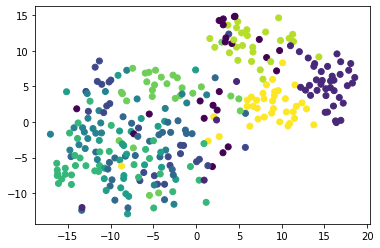

In [ ]:
# Convert y_train back to categoricals so matplotlib knows what to do with it
plt.scatter(transformed[:,0], transformed[:,1], c=np.where(1 == y_train[:num_images])[1])

Clearly, there is a good separation between the classes, which is normal given the supervised task of the network... Even better, let's show the original images:

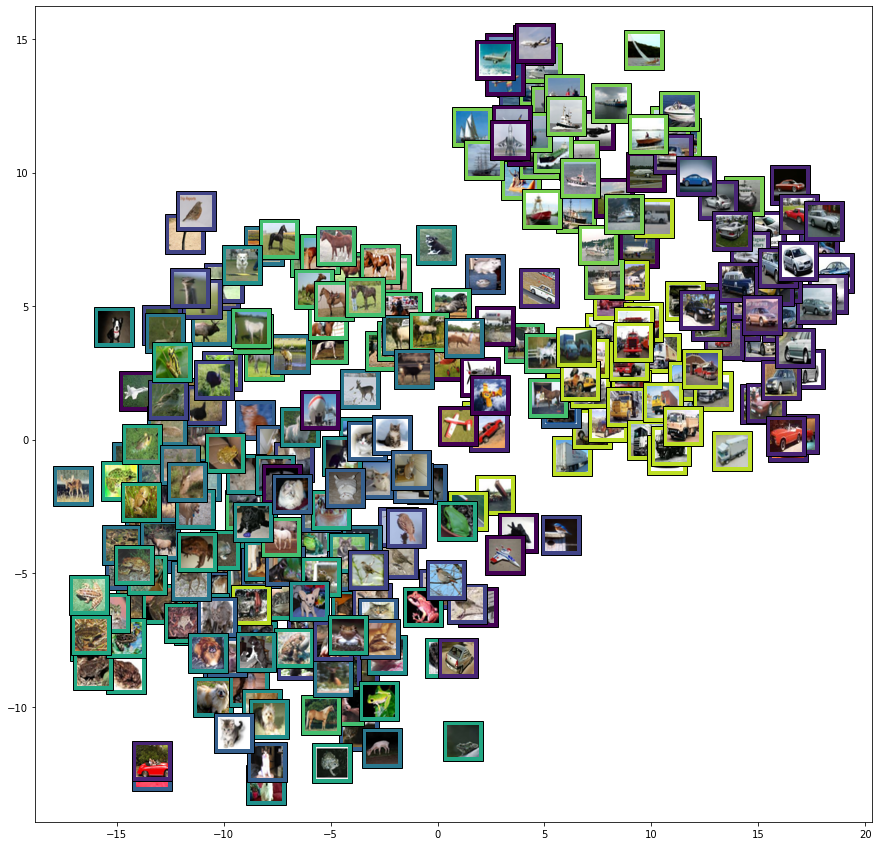

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(transformed[:,0], transformed[:,1], c=np.where(1 == y_train[:num_images])[1])

for i, t in enumerate(transformed):
  ab = AnnotationBbox(OffsetImage(X_train[i]), (t[0], t[1]), bboxprops=dict(
    fill=True,
    fc=plt.get_cmap('viridis')(
        np.where(1 == y_train[i])[0][0] / num_classes
    )
  ))
  ax.add_artist(ab)

plt.show()

Let's do the same for an intermediate convolutional layer.

In [ ]:
num_images      = 300
get_activations = get_layer_output(model, 'conv2d_2')
activations     = get_activations(X_train[:num_images])[0]
activations_filter = activations.mean(axis=(1,2)) # Mean activations per filter
activations_filter.shape

(300, 64)

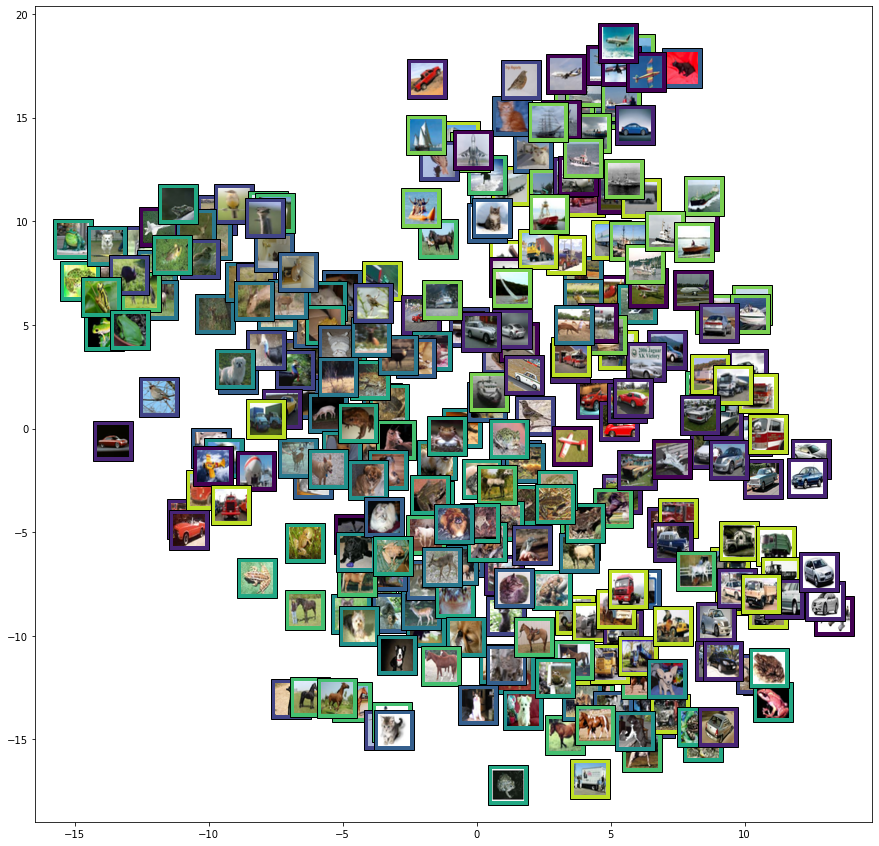

In [ ]:
tsne = TSNE()
transformed = tsne.fit_transform(activations_filter)

fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(transformed[:,0], transformed[:,1], c=np.where(1 == y_train[:num_images])[1])

for i, t in enumerate(transformed):
  ab = AnnotationBbox(OffsetImage(X_train[i]), (t[0], t[1]), bboxprops=dict(
    fill=True,
    fc=plt.get_cmap('viridis')(
        np.where(1 == y_train[i])[0][0] / num_classes
    )
  ))
  ax.add_artist(ab)

plt.show()

Or for all the activations of a single filter:

In [ ]:
num_images      = 300
get_activations = get_layer_output(model, 'conv2d_2')
activations     = get_activations(X_train[:num_images])[0]
# Filter nr. 5 and reshape to flatten
activations_filter = activations[:,:,:,5].reshape((num_images, activations.shape[1] * activations.shape[2]))
activations_filter.shape

(300, 784)

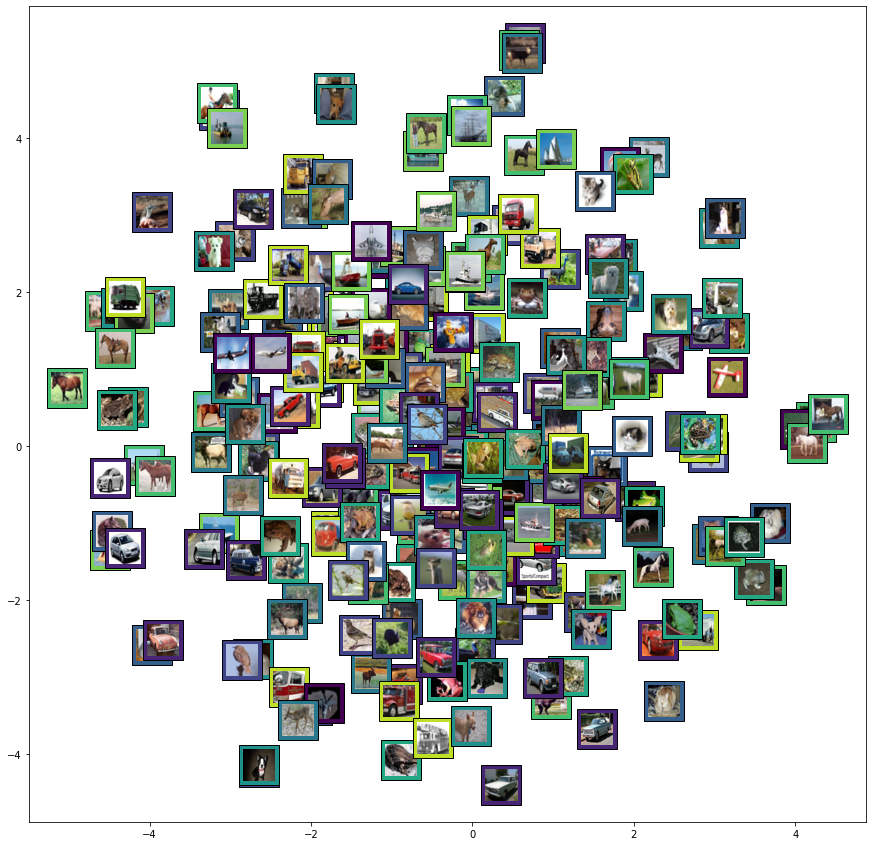

In [ ]:
tsne = TSNE()
transformed = tsne.fit_transform(activations_filter)

fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(transformed[:,0], transformed[:,1], c=np.where(1 == y_train[:num_images])[1])

for i, t in enumerate(transformed):
  ab = AnnotationBbox(OffsetImage(X_train[i]), (t[0], t[1]), bboxprops=dict(
    fill=True,
    fc=plt.get_cmap('viridis')(
        np.where(1 == y_train[i])[0][0] / num_classes
    )
  ))
  ax.add_artist(ab)

plt.show()

Finally, one wonders what happens if we run t-SNE directly on the input images. Let's compare this with the output of the global average pooling layer.

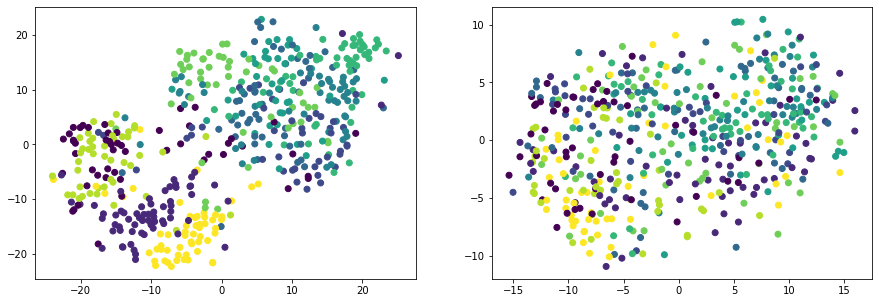

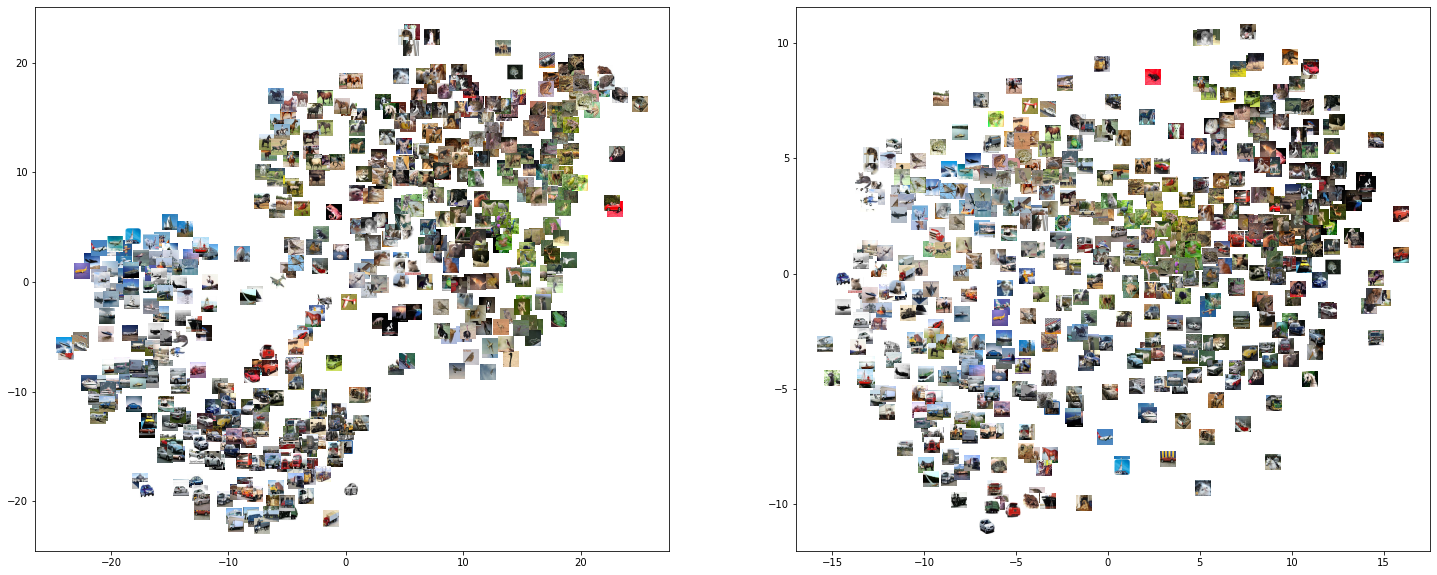

In [ ]:
num_images      = 500
get_activations = get_layer_output(model, 'global_average_pooling2d')
activations     = get_activations(X_train[:num_images])[0]

tsne = TSNE()
transformed_dense = tsne.fit_transform(activations)
transformed_input = tsne.fit_transform(X_train[:num_images].reshape(
  (num_images, X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(transformed_dense[:,0], transformed_dense[:,1], c=np.where(1 == y_train[:num_images])[1])
ax[1].scatter(transformed_input[:,0], transformed_input[:,1], c=np.where(1 == y_train[:num_images])[1])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(25, 10))
ax[0].scatter(transformed_dense[:,0], transformed_dense[:,1], c=np.where(1 == y_train[:num_images])[1])
ax[1].scatter(transformed_input[:,0], transformed_input[:,1], c=np.where(1 == y_train[:num_images])[1])
for i, t in enumerate(transformed_dense):
  ab = AnnotationBbox(OffsetImage(X_train[i], zoom=.5), (t[0], t[1]), frameon=False)
  ax[0].add_artist(ab)
for i, t in enumerate(transformed_input):
  ab = AnnotationBbox(OffsetImage(X_train[i], zoom=.5), (t[0], t[1]), frameon=False)
  ax[1].add_artist(ab)
plt.show()

Note the differences between the supervised and completely unsupervised approach. Applying t-SNE on the input images directly "clusters" them mainly on hue and brightness, whereas our neural network focuses first on the given label, as is expected.